In [12]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The forward and backward passes

[Jump_to lesson 8 video](https://course19.fast.ai/videos/?lesson=8&t=4960)

**Normalize just get the tensor subtracts the mean and divide by standart deviation**

In [13]:
#export
from exp.nb_01 import *

def get_data():
    # I removed below and add the direct path from my computer.
    #path = datasets.download_data(MNIST_URL, ext='.gz')
    path = Path()/'mnist.pkl.gz'
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

def normalize(x, m, s): return (x-m)/s

In [14]:
x_train,y_train,x_valid,y_valid = get_data()

In [15]:
train_mean,train_std = x_train.mean(),x_train.std()
train_mean,train_std

(tensor(0.1304), tensor(0.3073))

### Normalize validations set with ```train_mean``` and ```train_std``` not its own values

In [16]:
x_train = normalize(x_train, train_mean, train_std)
# NB: Use training, not validation mean for validation set
x_valid = normalize(x_valid, train_mean, train_std)

> Note: We want ```mean``` 0 and ```std```1

In [17]:
train_mean,train_std = x_train.mean(),x_train.std()
train_mean,train_std

(tensor(2.1325e-08), tensor(1.))

In [18]:
#export
def test_near_zero(a,tol=1e-3): assert a.abs()<tol, f"Near zero: {a}"

In [36]:
x_valid.mean(),x_valid.std()

(tensor(-0.0059), tensor(0.9924))

In [19]:
test_near_zero(x_train.mean())
test_near_zero(1-x_train.std())

In [20]:
n,m = x_train.shape
c = y_train.max()+1
n,m,c

(50000, 784, tensor(10))

## Foundations version

### Basic architecture

[Jump_to lesson 8 video](https://course19.fast.ai/videos/?lesson=8&t=5128)

In [21]:
# num hidden
nh = 50

[Tinker practice](https://course19.fast.ai/videos/?lesson=8&t=5255)

> Note: We need everything (weights and biases) ```mean()``` close to the zero and ```std()``` standart deviation close to 1. It also applies to  input and input to the second layer

> Note: **A note to myself: These ```t.mean()```,```t.std()``` can be used while for neuroevolution**

In [22]:
# standard xavier init
w1 = torch.randn(m,nh)/math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)/math.sqrt(nh)
b2 = torch.zeros(1)

In [34]:
test_near_zero(w1.mean())
# NK_ WHAT IS THIS?
test_near_zero(w1.std()-1/math.sqrt(m))

In [33]:
# This should be ~ (0,1) (mean,std)...
x_valid.mean(),x_valid.std()

(tensor(-0.0059), tensor(0.9924))

In [25]:
def lin(x, w, b): return x@w + b

In [26]:
t = lin(x_valid, w1, b1)

In [27]:
#...so should this, because we used xavier init, which is designed to do this
t.mean(),t.std()

(tensor(-0.0662), tensor(0.9336))

> Note: above looks ok but there is also a relu in the first layer

In [28]:
def relu(x): return x.clamp_min(0.)

In [29]:
t = relu(lin(x_valid, w1, b1))

# Homework :2.2 Reading

> Note: This does'not look good and this is why. We remove everything below zero! Read 2.2 of [Delving Deep into Rectifiers](https://arxiv.org/pdf/1502.01852.pdf)

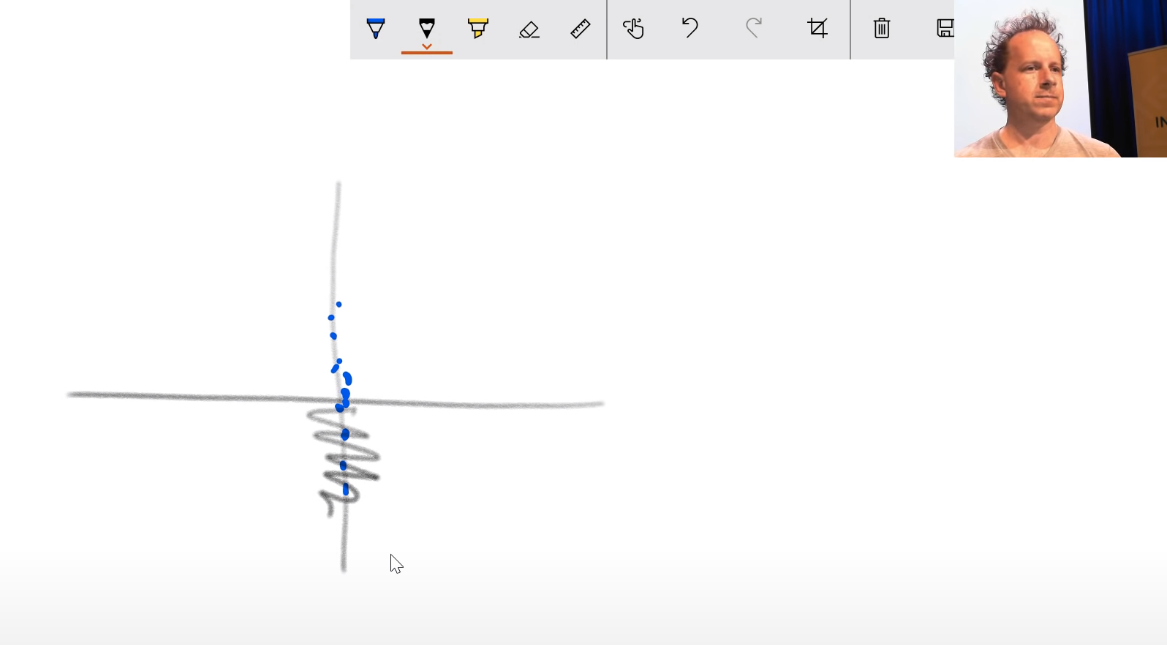

> Note: The variance ```t.std()``` halves and the mean ```t.mean()```  become larger

In [30]:
#...actually it really should be this!
t.mean(),t.std()

(tensor(0.3371), tensor(0.5230))

From pytorch docs: `a: the negative slope of the rectifier used after this layer (0 for ReLU by default)`

$$\text{std} = \sqrt{\frac{2}{(1 + a^2) \times \text{fan_in}}}$$

This was introduced in the paper that described the Imagenet-winning approach from *He et al*: [Delving Deep into Rectifiers](https://arxiv.org/abs/1502.01852), which was also the first paper that claimed "super-human performance" on Imagenet (and, most importantly, it introduced resnets!)

[Jump_to lesson 8 video](https://course19.fast.ai/videos/?lesson=8&t=5128)

In [37]:
# kaiming init / he init for relu
w1 = torch.randn(m,nh)*math.sqrt(2/m)

std is very low as in the xavier init.

In [38]:
w1.mean(),w1.std()

(tensor(2.3088e-05), tensor(0.0506))

**This result is very close to Pytorch's kaiming_normal initialization.** See below

In [39]:
t = relu(lin(x_valid, w1, b1))
t.mean(),t.std()

(tensor(0.6027), tensor(0.8792))

In [33]:
#export
from torch.nn import init

normally `fan_out` part is correspond to `*math.sqrt(2/m)` part above but with a trick. According to paper it must be `fan_in`  but Torch initiliase the layer not by m*nh but nh*m so do not worry about it.

In [34]:
w1 = torch.zeros(m,nh)
init.kaiming_normal_(w1, mode='fan_out') #this is original
t = relu(lin(x_valid, w1, b1))

In [35]:
init.kaiming_normal_??

Signature: init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')
Source:   
def kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu'):
    r"""Fills the input `Tensor` with values according to the method
    described in `Delving deep into rectifiers: Surpassing human-level
    performance on ImageNet classification` - He, K. et al. (2015), using a
    normal distribution. The resulting tensor will have values sampled from
    :math:`\mathcal{N}(0, \text{std}^2)` where

    .. math::
        \text{std} = \frac{\text{gain}}{\sqrt{\text{fan\_mode}}}

    Also known as He initialization.

    Args:
        tensor: an n-dimensional `torch.Tensor`
        a: the negative slope of the rectifier used after this layer (only
            used with ``'leaky_relu'``)
        mode: either ``'fan_in'`` (default) or ``'fan_out'``. Choosing ``'fan_in'``
            preserves the magnitude of the variance of the weights in the
            forward pass. Choosing ``

In [36]:
w1.mean(),w1.std()

(tensor(-0.0006), tensor(0.0502))

**This result is very close to Jeremy's  kaiming_normal initialization.** See above

In [37]:
t.mean(),t.std()

(tensor(0.5045), tensor(0.7602))

In [38]:
w1.shape

torch.Size([784, 50])

In [39]:
import torch.nn

In [40]:
torch.nn.Linear(m,nh).weight.shape

torch.Size([50, 784])

In [41]:
torch.nn.Linear.forward??

Signature: torch.nn.Linear.forward(self, input: torch.Tensor) -> torch.Tensor
Docstring:
Defines the computation performed at every call.

Should be overridden by all subclasses.

.. note::
    Although the recipe for forward pass needs to be defined within
    this function, one should call the :class:`Module` instance afterwards
    instead of this since the former takes care of running the
    registered hooks while the latter silently ignores them.
Source:   
    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)
File:      ~/mambaforge/lib/python3.9/site-packages/torch/nn/modules/linear.py
Type:      function


In [42]:
torch.nn.functional.linear??

Docstring:
linear(input, weight, bias=None) -> Tensor

Applies a linear transformation to the incoming data: :math:`y = xA^T + b`.

This operator supports :ref:`TensorFloat32<tf32_on_ampere>`.

Shape:

    - Input: :math:`(*, in\_features)` where `*` means any number of
      additional dimensions, including none
    - Weight: :math:`(out\_features, in\_features)` or :math:`(in\_features)`
    - Bias: :math:`(out\_features)` or :math:`()`
    - Output: :math:`(*, out\_features)` or :math:`(*)`, based on the shape of the weight
Type:      builtin_function_or_method


In [43]:
torch.nn.Conv2d??

Init signature:
torch.nn.Conv2d(
    in_channels: int,
    out_channels: int,
    kernel_size: Union[int, Tuple[int, int]],
    stride: Union[int, Tuple[int, int]] = 1,
    padding: Union[str, int, Tuple[int, int]] = 0,
    dilation: Union[int, Tuple[int, int]] = 1,
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies a 2D convolution over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size
:math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
can be precisely described as:

.. math::
    \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
    \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


where :math:`\star` is the valid 2D `cross-correlation`_ operator,
:math:`N` is a batch size, :math:`C` denotes a number of chann

In [44]:
torch.nn.modules.conv._ConvNd.reset_parameters??

Signature: torch.nn.modules.conv._ConvNd.reset_parameters(self) -> None
Docstring: <no docstring>
Source:   
    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(k), 1/sqrt(k)), where k = weight.size(1) * prod(*kernel_size)
        # For more details see: https://github.com/pytorch/pytorch/issues/15314#issuecomment-477448573
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                init.uniform_(self.bias, -bound, bound)
File:      ~/mambaforge/lib/python3.9/site-packages/torch/nn/modules/conv.py
Type:      function


> Note: -0.5 helps both mean and std.

In [41]:
# kaiming init / he init for relu
w1 = torch.randn(m,nh)*math.sqrt(2./m )
t1 = relu(lin(x_valid, w1, b1))
t1.mean(),t1.std()

(tensor(0.0760), tensor(0.8486))

In [42]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    l3 = lin(l2, w2, b2)
    return l3

In [50]:
%timeit -n 10 _=model(x_valid)

4.83 ms ± 408 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
assert model(x_valid).shape==torch.Size([x_valid.shape[0],1])

### Loss function: MSE

[Jump_to lesson 8 video](https://course19.fast.ai/videos/?lesson=8&t=6372)

In [94]:
model(x_valid).shape

torch.Size([10000, 1])

We need `squeeze()` to get rid of that trailing (,1), in order to use `mse`. (Of course, `mse` is not a suitable loss function for multi-class classification; we'll use a better loss function soon. We'll use `mse` for now to keep things simple.)

In [95]:
#export
def mse(output, targ): return (output.squeeze(-1) - targ).pow(2).mean()

In [96]:
y_train,y_valid = y_train.float(),y_valid.float()

In [100]:
y_valid.shape

torch.Size([10000])

In [97]:
preds = model(x_train)

In [98]:
preds.shape

torch.Size([50000, 1])

In [101]:
mse(preds, y_train)

tensor(33.0854)

### Gradients and backward pass

[Jump_to lesson 8 video](https://course19.fast.ai/videos/?lesson=8&t=6493)

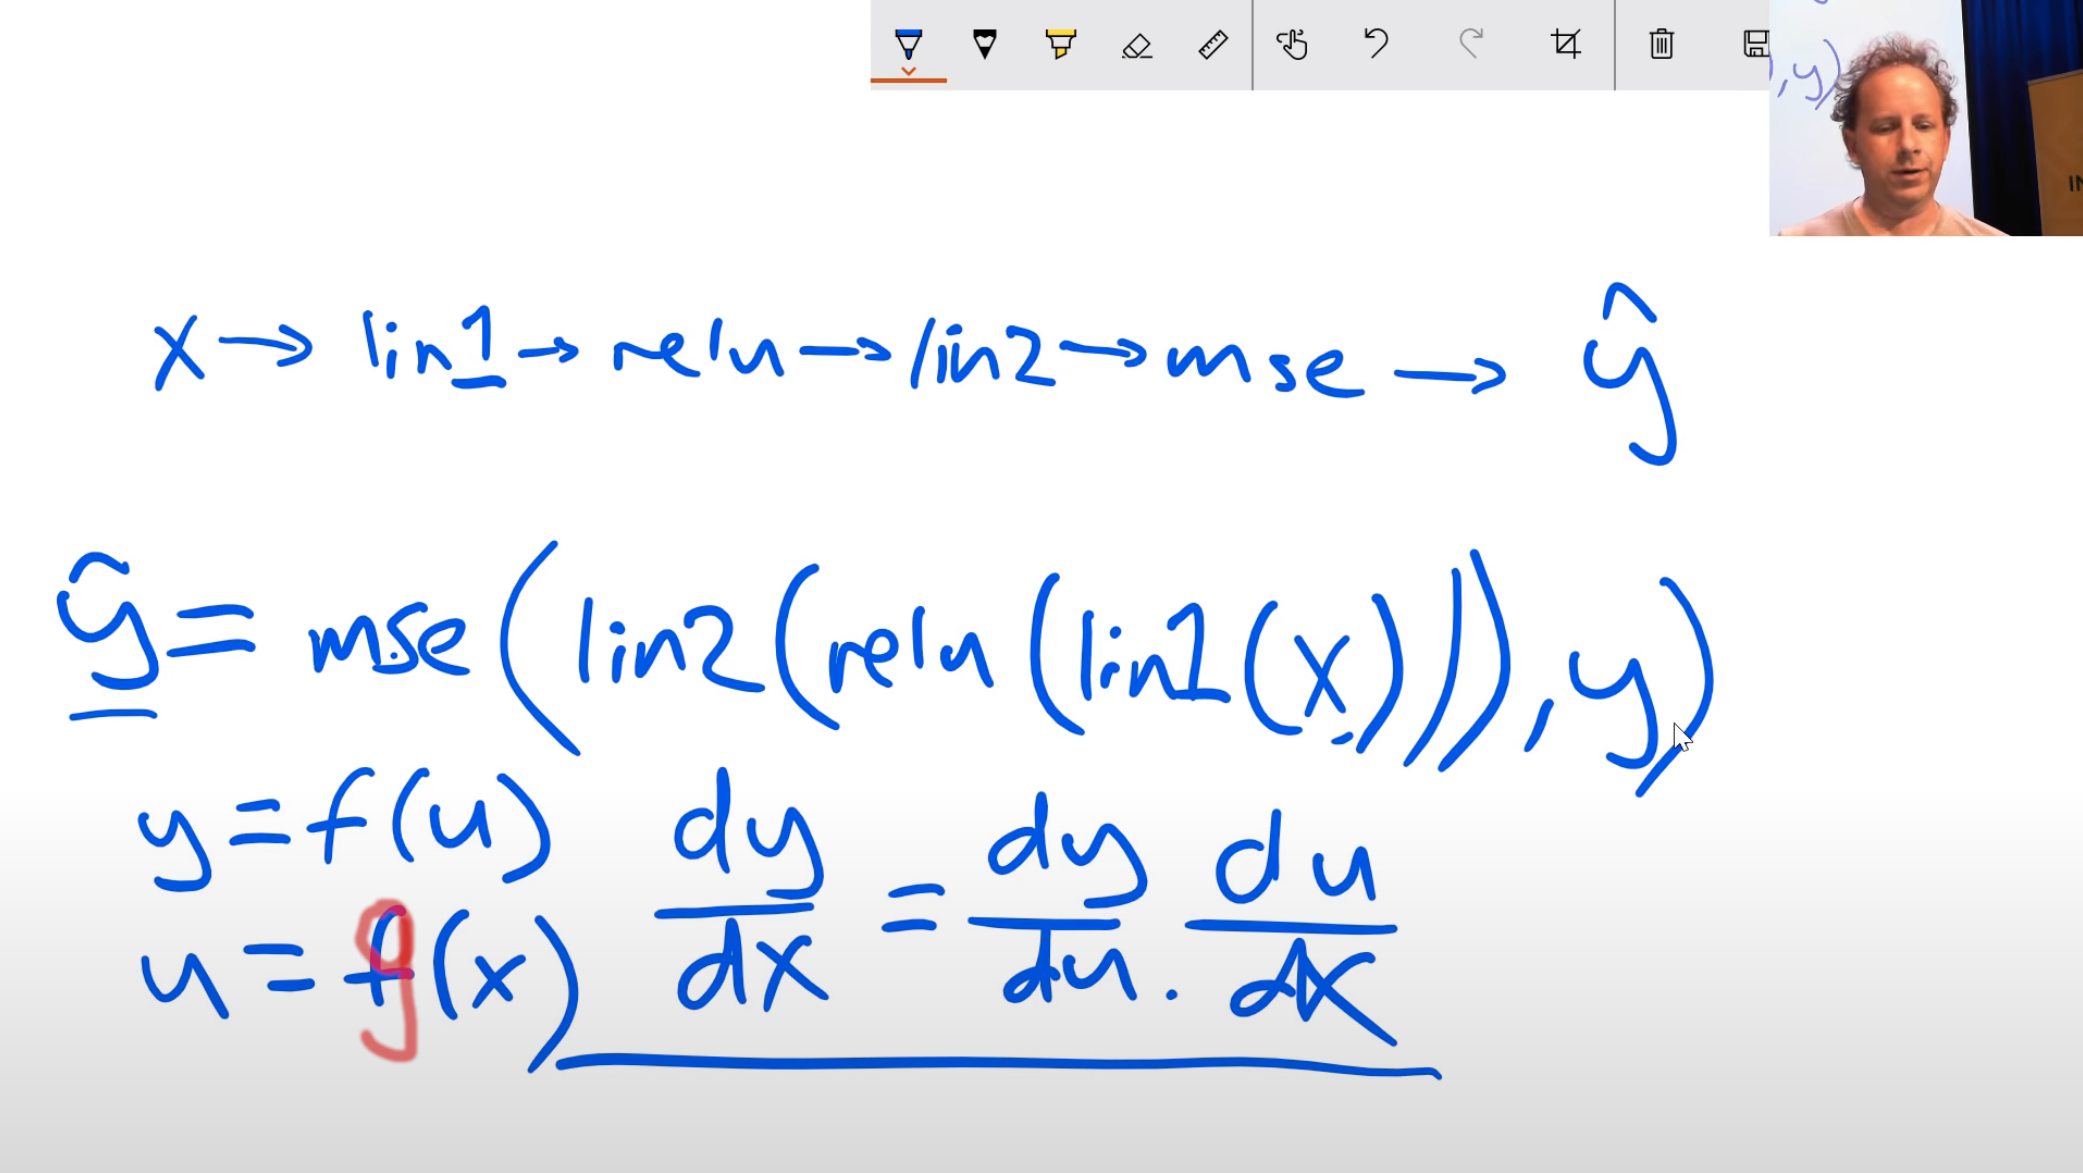

Read this understand what is going on below.<br>[The Matrix Calculus You Need For Deep Learning](https://explained.ai/matrix-calculus/index.html)

# Homework

**There is a complete (and great) explanation of backward and forward passes. Watch whe video if needed.**

In [102]:
def mse_grad(inp, targ): 
    # grad of loss with respect to output of previous layer
    inp.g = 2. * (inp.squeeze() - targ).unsqueeze(-1) / inp.shape[0]

In [103]:
def relu_grad(inp, out):
    # grad of relu with respect to input activations
    inp.g = (inp>0).float() * out.g

In [104]:
def lin_grad(inp, out, w, b):
    # grad of matmul with respect to input
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [105]:
def forward_and_backward(inp, targ):
    # forward pass:
    l1 = inp @ w1 + b1
    l2 = relu(l1)
    out = l2 @ w2 + b2
    # we don't actually need the loss in backward!
    loss = mse(out, targ)
    
    # backward pass:
    mse_grad(out, targ)
    lin_grad(l2, out, w2, b2)
    relu_grad(l1, l2)
    lin_grad(inp, l1, w1, b1)

In [106]:
forward_and_backward(x_train, y_train)

In [107]:
# Save for testing against later
w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()
ig  = x_train.g.clone()

We cheat a little bit and use PyTorch autograd to check our results.

In [110]:
xt2 = x_train.clone().requires_grad_(True)
w12 = w1.clone().requires_grad_(True)
w22 = w2.clone().requires_grad_(True)
b12 = b1.clone().requires_grad_(True)
b22 = b2.clone().requires_grad_(True)

In [108]:
def forward(inp, targ):
    # forward pass:
    l1 = inp @ w12 + b12
    l2 = relu(l1)
    out = l2 @ w22 + b22
    # we don't actually need the loss in backward!
    return mse(out, targ)

In [112]:
loss = forward(xt2, y_train)

In [113]:
loss.backward()

In [114]:
test_near(w22.grad, w2g)
test_near(b22.grad, b2g)
test_near(w12.grad, w1g)
test_near(b12.grad, b1g)
test_near(xt2.grad, ig )

# Homework :All Refactoring part

## Refactor model

### Layers as classes

[Jump_to lesson 8 video](https://course19.fast.ai/videos/?lesson=8&t=7112)

In [123]:
class Relu():
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.)-0.5
        return self.out
    
    def backward(self): self.inp.g = (self.inp>0).float() * self.out.g

In [115]:
class Lin():
    def __init__(self, w, b): self.w,self.b = w,b
        
    def __call__(self, inp):
        self.inp = inp
        self.out = inp@self.w + self.b
        return self.out
    
    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        # Creating a giant outer product, just to sum it, is inefficient!
        self.w.g = (self.inp.unsqueeze(-1) * self.out.g.unsqueeze(1)).sum(0)
        self.b.g = self.out.g.sum(0)

In [116]:
class Mse():
    def __call__(self, inp, targ):
        self.inp = inp
        self.targ = targ
        self.out = (inp.squeeze() - targ).pow(2).mean()
        return self.out
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [121]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [124]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model(w1, b1, w2, b2)

In [125]:
%time loss = model(x_train, y_train)

CPU times: user 169 ms, sys: 13.9 ms, total: 183 ms
Wall time: 30 ms


In [126]:
%time model.backward()

CPU times: user 6.72 s, sys: 2.93 s, total: 9.65 s
Wall time: 1.75 s


In [127]:
test_near(w2g, w2.g)
test_near(b2g, b2.g)
test_near(w1g, w1.g)
test_near(b1g, b1.g)
test_near(ig, x_train.g)

> Important: Below is the continuation of refactoring. It removes the duplicates like, makes the code neat:<br>
```Python
    self.inp=inp
```

### Module.forward()

In [128]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)

In [129]:
class Relu(Module):
    def forward(self, inp): return inp.clamp_min(0.)-0.5
    def bwd(self, out, inp): inp.g = (inp>0).float() * out.g

In [130]:
class Lin(Module):
    def __init__(self, w, b): self.w,self.b = w,b
        
    def forward(self, inp): return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = torch.einsum("bi,bj->ij", inp, out.g)
        self.b.g = out.g.sum(0)

In [131]:
class Mse(Module):
    def forward (self, inp, targ): return (inp.squeeze() - targ).pow(2).mean()
    def bwd(self, out, inp, targ): inp.g = 2*(inp.squeeze()-targ).unsqueeze(-1) / targ.shape[0]

In [132]:
class Model():
    def __init__(self):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [133]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model()

In [134]:
%time loss = model(x_train, y_train)

CPU times: user 197 ms, sys: 700 µs, total: 198 ms
Wall time: 32.6 ms


In [135]:
%time model.backward()

CPU times: user 387 ms, sys: 117 ms, total: 504 ms
Wall time: 85.8 ms


In [136]:
test_near(w2g, w2.g)
test_near(b2g, b2.g)
test_near(w1g, w1.g)
test_near(b1g, b1.g)
test_near(ig, x_train.g)

### Without einsum

[Jump_to lesson 8 video](https://course19.fast.ai/videos/?lesson=8&t=7484)

In [77]:
class Lin(Module):
    def __init__(self, w, b): self.w,self.b = w,b
        
    def forward(self, inp): return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = out.g.sum(0)

In [78]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model()

In [79]:
%time loss = model(x_train, y_train)

CPU times: user 184 ms, sys: 2.81 ms, total: 187 ms
Wall time: 30.7 ms


In [80]:
%time model.backward()

CPU times: user 310 ms, sys: 115 ms, total: 425 ms
Wall time: 70.9 ms


In [81]:
test_near(w2g, w2.g)
test_near(b2g, b2.g)
test_near(w1g, w1.g)
test_near(b1g, b1.g)
test_near(ig, x_train.g)

### nn.Linear and nn.Module

In [82]:
#export
from torch import nn

In [83]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        self.loss = mse
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x.squeeze(), targ)

In [84]:
model = Model(m, nh, 1)

In [85]:
%time loss = model(x_train, y_train)

CPU times: user 167 ms, sys: 9.3 ms, total: 177 ms
Wall time: 29.5 ms


In [86]:
%time loss.backward()

CPU times: user 238 ms, sys: 153 µs, total: 238 ms
Wall time: 40 ms


## Export

In [87]:
!./notebook2script.py 02_fully_connected.ipynb

Converted 02_fully_connected.ipynb to exp/nb_02.py


**Homework: Read 2.2 of** [Delving Deep into Rectifiers](https://arxiv.org/pdf/1502.01852.pdf)
